# Generate Profiles for the Buses based on the Pypsa-Earth profiles 

This script generates a series of load profiles for different projection years so that they can be given as input to the pypsa model for optimization

In [23]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Import all dirs
parent_dir = Path(os.getcwd()).parents[0]
sys.path.append(str(parent_dir))
from src.paths import all_dirs
dirs = all_dirs()


The following file has demand information, lets explore it

In [24]:
import os
import pandas as pd
from typing import Tuple, Dict

# -------------------------------------------------------------------
# EXPECTED PRE-DEFINED VARS 

# base_scenario         -> "trend" | "base" | "productive_mix" 
# year_projection_end   -> 2050  (not used directly here)
# output_path
# load_df path:
# -------------------------------------------------------------------

TARGET_YEARS = [2030, 2040, 2050]
SCENARIOS = ["trend", "base", "productive_mix"]
METHODS = ["linear", "exponential"]
OUTDIR = dirs["data/processed/scaled_loads"]
DEMAND_DATA_DIR = dirs["data/raw/demand"]
os.makedirs(OUTDIR, exist_ok=True)

# ----------------- Load inputs -----------------
# 1) Hourly load profiles
load_path = os.path.join(DEMAND_DATA_DIR, "demand_profiles_EC.csv")
load_df = pd.read_csv(load_path)
if "time" not in load_df.columns:
    raise ValueError("Expected a 'time' column in demand_profiles.csv")
load_df["time"] = pd.to_datetime(load_df["time"])
load_df = load_df.set_index("time")
# (Now each column is a bus; values per hour)

# 2) Historic (2018–2027) — columns: year, tendencial, caso_base, matriz_productiva
csv_path_hist = os.path.join(DEMAND_DATA_DIR, "demand_ec_2018_2027.csv")
hist_df = pd.read_csv(csv_path_hist)
hist_df.columns = [c.strip().lower() for c in hist_df.columns]
hist_df["year"] = hist_df["year"].astype(int)
hist_df = hist_df.set_index("year")

# ----------------- Helpers -----------------
def compute_total_energy(df: pd.DataFrame) -> float:
    """Total energy (GWh) = sum over all hours and buses."""
    return float(df.sum().sum())


def find_closest_historic(
    hist: pd.DataFrame, total_energy: float, scenario: str
) -> Tuple[int, str, float]:
    """Find (year, scenario, value) in historic closest to total_energy."""
    best = None
    for y, row in hist.iterrows():
        val = row.get(scenario)
        if pd.notna(val):
            diff = abs(float(val) - total_energy)
            cand = (y, scenario, float(val), diff)
            if (best is None) or (diff < best[3]):
                best = cand
    if best is None:
        raise ValueError("Historic table has no usable values.")
    return best[0], best[1], best[2]


def projected_total(row: pd.Series, scenario: str, method: str) -> float:
    """
    Map scenarios to projection columns.
    """
    method = (
        method.lower()
    )  #  matriz_productiva_proj_linear_GWh, matriz_productiva_proj_exponential_GWh
    # if scenario == "matriz_productiva":
    col = f"proj_{method}_gwh"
    if col not in row.index or pd.isna(row[col]):
        raise KeyError(f"Projection column '{col}' missing for year {int(row.name)}.")
    return float(row[col])


def scale_and_write(
    df: pd.DataFrame, factor: float, year: int, scenario: str, outdir: str, method: str
) -> str:
    scaled = df * factor
    
    # --- Assert max 2 decimals ---
    rounded = scaled.round(2)
    diff = (scaled - rounded).abs().max().max()
    #assert diff < 1e-9, f"Values in scaled DataFrame have more than 2 decimals (max diff: {diff})"
    
    # --- Prepare output ---
    out = rounded.copy()
    out.insert(0, "timestamp", out.index.astype(str))
    fname = f"load_{scenario}_{year}_{method}.csv"
    fpath = os.path.join(outdir, fname)
    out.to_csv(fpath, index=False)
    return fpath



In [25]:
# ----------------- Workflow -----------------
total_now = compute_total_energy(load_df)
print(f"Current total energy (from load_df): {total_now/1e6:.3f} TWh")

Current total energy (from load_df): 33.406 TWh


Plot the yearly energy demand

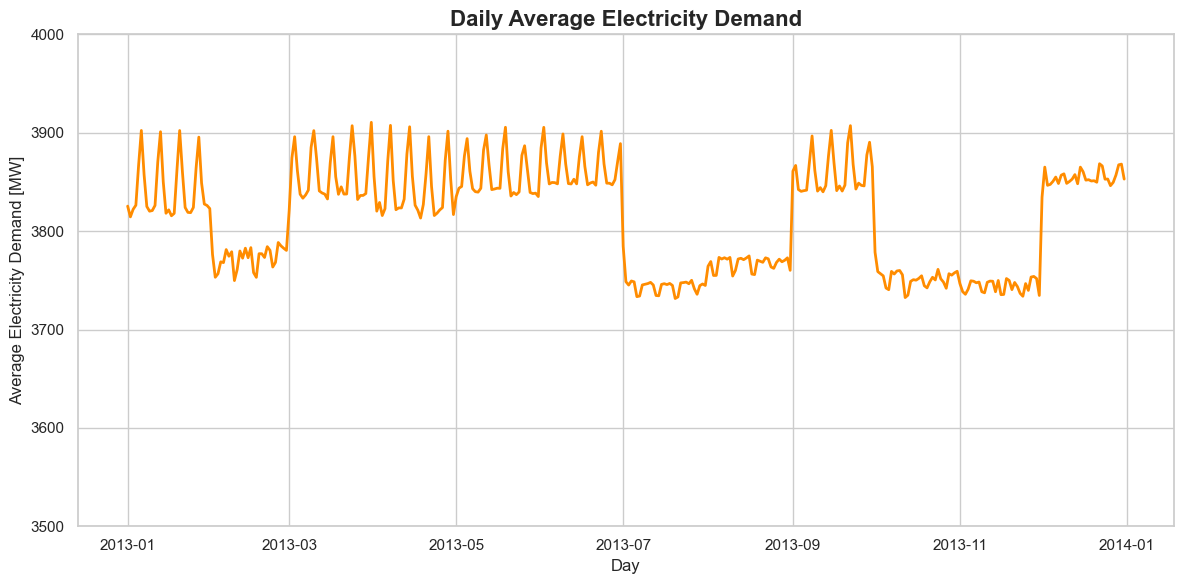

In [28]:
sum = load_df.sum(axis=1)
weekly_demand = sum.resample("D").mean()

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(
    x=weekly_demand.index, y=weekly_demand.values, linewidth=2, color="darkorange"
)

plt.title("Daily Average Electricity Demand", fontsize=16, weight="bold")
plt.xlabel("Day", fontsize=12)
plt.ylabel("Average Electricity Demand [MW]", fontsize=12)
plt.ylim(3500, 4000)
plt.tight_layout()

# Save figure
plt.savefig(
    os.path.join(dirs["results/graphs"], "ecuador_elec_profile.png"),
    dpi=600,
)

In [27]:
records: Dict[str, Dict] = {}

base_val = compute_total_energy(load_df) / (10**6)  # in TWh
for method in METHODS:
    for year in TARGET_YEARS:
        for scen in SCENARIOS:
            projection_path = dirs["data/processed"]
            projection_file = os.path.join(
                projection_path, f"demand_projection_2018_2050_{scen}.csv"
            )
            proj_df = pd.read_csv(projection_file, index_col=0)
            if year not in proj_df.index:
                raise KeyError(f"Year {year} not found in projections file: \n{projection_file}")
            prow = proj_df.loc[year]
            target_total = projected_total(prow, scen, method)
            factor = target_total / base_val
            out_path_file = scale_and_write(load_df, factor, year, scen, OUTDIR, method)
            key = f"{scen}_{year}"
            records[key] = {
                "year": year,
                "scenario": scen,
                "method": method,
                "baseline_value_GWh": round(base_val, 2),
                "target_total_GWh": round(target_total, 2),
                "scaling_factor": round(factor, 2),
                # "output_file": out_path_file,
            }

# Summary
summary = pd.DataFrame.from_dict(records, orient="index")
summary_path = os.path.join(OUTDIR, "factors_summary.csv")
summary.to_csv(summary_path, index=False)
print(f"Summary written: {summary_path}")

Summary written: c:\Repositories\Repos\pypsa-earth-project\EcuadorElectricGrid\data\processed\scaled_loads\factors_summary.csv
